# First Baseline Model - Random Forest

#### ``Objectives``
1. Implement a Baseline MOdels for run value prediction PRE BATTED-BALL
2. Turn to a Random Forest for the another baseline model

**TO DO:**
- add count
- add times faced


### Import Libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# decision tree
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestRegressor


# random forest

# misc
import os
import glob


#### Clear output and stored data:



In [6]:
os.system('clear') 

0

---
#### <span style="color:chocolate">  Step 1: Data ingestion </span>

I already created the training data in another file:
 <span style="color:gray">TrackMan data of 2024 spring season</span> function below according to the following guidelines:

 a) Read all the csv files in the directory and merge them into a single dataframe \
 b) Save the dataframe to a csv file

In [35]:
# dont need to run this again since already created the training data

def load_data(path: str, num_columns=60) -> pd.DataFrame:
    """
    Loads and merges CSV files from the specified directory, excluding files with 'player positioning' in their names.
    
    Parameters:
    path (str): The directory path containing the CSV files.

    Returns:
    pandas.DataFrame: The merged DataFrame containing data from the selected CSV files.
    """
    try:
        # Ensure the directory exists
        if not os.path.exists(path):
            raise FileNotFoundError(f"The directory '{path}' does not exist.")

        # Get all files in the directory that end with .csv, excluding those with 'player positioning' in the name
        all_files = [
            file for file in glob.glob(f"{path}/*.csv") if 'player positioning' not in file
        ]

        # Raise an exception if no valid files are found
        if not all_files:
            raise ValueError(f"No valid CSV files found in the directory '{path}'.")

        # Set the indices of the columns to keep
        columns_to_keep = list(range(num_columns))  # will set that in the function call but usually 60 will be fine

        # Read and merge the filtered files with the specified columns
        df_list = [pd.read_csv(filename, usecols=columns_to_keep) for filename in all_files]
        merged_df = pd.concat(df_list, ignore_index=True)

        # Save the merged DataFrame to a CSV
        output_path = "/Users/tommayer/Desktop/games_test.csv"
        merged_df.to_csv(output_path, index=False)

        return merged_df

    except FileNotFoundError as fnf_error:
        print(f"Error: {fnf_error}")
    except ValueError as val_error:
        print(f"Error: {val_error}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")


#### NOTE: 
I don't know if it's smart to load the data and concatenate all rows every time.  I could make it more like appending rows to the dataframe.

In [9]:
# ONLY COLUMNS with data from pre-batted ball + RunsScored as our target variable
required_columns = ['TaggedPitchType', 'AutoPitchType', 'RunsScored', 'RelSpeed', 'RelHeight', 'VertRelAngle',
                     'HorzRelAngle','SpinRate', 'SpinAxis', 'Tilt', 'Extension','InducedVertBreak', 'HorzBreak',
                       'VertApprAngle', 'HorzApprAngle', 'GameID', 'Inning', 'Top/Bottom']

In [10]:
path = "/Users/tommayer/Desktop/training_data.csv"
#data = load_data(path)
data = pd.read_csv(path, usecols=required_columns)
## drastically reduces the number of rows and columns -> way less memory

In [11]:
# peer at data and get a sense of the shape
data.head(5)
#print(f'Data shape: {data.shape}')

,Inning,Top/Bottom,TaggedPitchType,AutoPitchType,RunsScored,RelSpeed,VertRelAngle,HorzRelAngle,SpinRate,SpinAxis,Tilt,RelHeight,Extension,InducedVertBreak,HorzBreak,VertApprAngle,HorzApprAngle,GameID
0,1,Top,Slider,Slider,0,86.34831,-5.087035,-0.556059,2514.190308,69.694698,8:15,6.89596,5.20061,-1.26150,-6.71201,-12.231122,-1.751516,20240302-OleMiss-1
1,1,Top,Fastball,Four-Seam,0,94.49974,-3.133086,-0.492520,2095.787589,190.374426,12:15,6.87165,5.83655,20.20828,3.49654,-5.365324,0.134391,20240302-OleMiss-1
2,1,Top,Fastball,Four-Seam,0,94.81021,-3.910073,-1.135525,1996.806823,178.803234,12:00,6.94572,5.67326,22.06875,-0.43740,-5.815582,-1.213668,20240302-OleMiss-1
3,1,Top,Slider,Slider,0,86.30865,-1.385858,-0.791508,3480.483920,100.930240,9:15,6.96039,5.43599,2.34610,-6.38485,-7.862841,-1.929632,20240302-OleMiss-1
4,1,Top,Slider,Slider,0,87.45870,-4.605749,-1.323250,1287.761851,79.042003,8:45,6.99938,5.28786,0.27646,-4.37162,-11.264591,-2.102031,20240302-OleMiss-1


---
#### <span style="color:chocolate"> Step 2: Exploratory data analysis (EDA) </span>
- check for missing values
- check for duplicates
- check for outliers
- check for class imbalance


Rows to be dropped if N/A: 
- our target variables
- name, date, location, team??


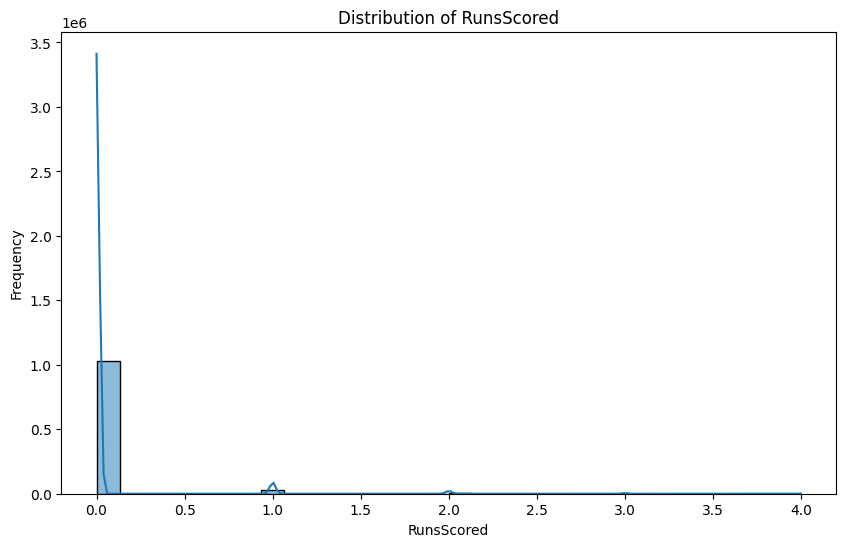

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of the target variable
plt.figure(figsize=(10, 6))
sns.histplot(data['RunsScored'], bins=30, kde=True)
plt.title('Distribution of RunsScored')
plt.xlabel('RunsScored')
plt.ylabel('Frequency')
plt.show()

In [13]:
# drop rows without certain columns
data = data.dropna(subset=required_columns)

In [14]:
# check how many rows were dropped
print(f'Number of rows dropped: {data.shape[0] - len(data)}')


Number of rows dropped: 0


Check data types:

In [15]:
print(data.dtypes)

Inning                int64
Top/Bottom           object
TaggedPitchType      object
AutoPitchType        object
RunsScored            int64
RelSpeed            float64
VertRelAngle        float64
HorzRelAngle        float64
SpinRate            float64
SpinAxis            float64
Tilt                 object
RelHeight           float64
Extension           float64
InducedVertBreak    float64
HorzBreak           float64
VertApprAngle       float64
HorzApprAngle       float64
GameID               object
dtype: object


In [16]:
independent_vars = data.drop(['RunsScored'], axis=1)
dependent_var = data['RunsScored']

In [17]:
# reference this down below so i dont have to list them out there
# Get column names by data type
categorical_columns = independent_vars.select_dtypes(include=['object']).columns.tolist()
numerical_columns = independent_vars.select_dtypes(include=['float64', 'int64']).columns.tolist()



In [18]:
print(f'Categorical columns: {categorical_columns}')
print(f'Numerical columns: {numerical_columns}')

Categorical columns: ['Top/Bottom', 'TaggedPitchType', 'AutoPitchType', 'Tilt', 'GameID']
Numerical columns: ['Inning', 'RelSpeed', 'VertRelAngle', 'HorzRelAngle', 'SpinRate', 'SpinAxis', 'RelHeight', 'Extension', 'InducedVertBreak', 'HorzBreak', 'VertApprAngle', 'HorzApprAngle']


Need to leave 'Top/Bottom', 'Inning', 'GameID' in the dataframe but not use them as features

### Feature Engineering:

In [45]:
# Add interaction terms between key features
"""
data['SpeedSpin'] = data['RelSpeed'] * data['SpinRate']
data['BreakComposite'] = data['InducedVertBreak'] * data['HorzBreak']

# Add polynomial features for important numerical variables
data['RelSpeed_Squared'] = data['RelSpeed'] ** 2
data['SpinRate_Squared'] = data['SpinRate'] ** 2 """

### New Target Variable: Run Expectancy

run_value = (RE_before - RE_after) + runs_scored_on_play

---
#### <span style="color:chocolate"> Step 3: Data Preprocessing </span>
- drop columns that are not useful?
- encode labels 
- split into training and testing data
- standardize data

Working with certain data types: \
a) numerical data (float, int)  \
    - scale data \
    - RelSpeed, SpinRate, InducedVertBreak, HorzBreak, ExitSpeed, etc \
    \
b) categorical data (object/string) \
    - encode data (one-hot encoding with sklearn LabelEncoder) \
    - TaggedPitchType, AutoPitchType, PitchCall, KorBB, TaggedHitType, PlayResult


In [19]:
def preprocess_data(data: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.Series, pd.Series, pd.Series]:
    """
    Preprocesses the data by identifying column types, encoding categorical data, and scaling numerical data.
    Returns train/test/validation splits of features and target.
    """
    
    # 1. Separate metadata columns we want to keep but not use as features
    metadata_cols = ['Top/Bottom', 'Inning', 'GameID']
    
    # 2. Identify column types (excluding metadata columns)
    feature_cols = [col for col in data.columns if col not in metadata_cols + ['RunsScored']]
    numerical_cols = data[feature_cols].select_dtypes(include=['int64', 'float64']).columns
    categorical_cols = data[feature_cols].select_dtypes(include=['object']).columns

    # 3. Create a copy of the data for feature engineering
    features_df = data[feature_cols].copy()
    
    # 4. Handle categorical data
    features_df = pd.get_dummies(features_df, columns=categorical_columns)

    # 5. Scale numerical features
    scaler = StandardScaler()
    numerical_features = numerical_columns
    features_df[numerical_features] = scaler.fit_transform(features_df[numerical_features])
    
    # 6. Add back metadata columns
    features_df = pd.concat([features_df, data[metadata_cols]], axis=1)

    # 7. Split into features and target
    X = features_df
    y = data['RunsScored']

    # 8. Split into train/test/validation sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
    
    print(f'X_train shape: {X_train.shape}')
    print(f'X_val shape: {X_val.shape}')
    print(f'X_test shape: {X_test.shape}')
    print(f'y_train shape: {y_train.shape}')
    print(f'y_val shape: {y_val.shape}')
    print(f'y_test shape: {y_test.shape}')

    return X_train, X_test, X_val, y_train, y_test, y_val

In [20]:
X_train, X_test, X_val, y_train, y_test, y_val = preprocess_data(data)

KeyError: "['Top/Bottom', 'GameID'] not in index"

In [ ]:
def calculate_future_runs(group):
    # Sum runs scored after each pitch until end of inning (RE_after)
    # RE_before = runs scored before the pitch
    group['future_runs'] = group['RunsScored'].iloc[::-1].cumsum().iloc[::-1] - group['RunsScored']
    return group

# Group by game and inning to respect boundaries
data = data.groupby(['GameID', 'InningID', 'Top/Bottom']).apply(calculate_future_runs)

In [48]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', 
                                    classes=np.unique(y_train), 
                                    y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

In [49]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils.class_weight import compute_sample_weight

# Compute sample weights based on class frequencies
sample_weights = compute_sample_weight('balanced', y_train)

---
#### <span style="color:chocolate"> Step 4: Modeling </span>
- train a decision tree
- train a random forest
- train a gradient boosting machine (XGBoost)
- compare the three models

# Run Expectancy Model
**Notes**
- GOAL: train the model to predict the number of runs scored in the rest of the inning after each pitch
- we will use this to calculate the run value of each pitch
- BIG IDEA: 
    - train a model to predict the number of runs scored in the rest of the inning after each pitch 
    - then, we can use this model to calculate the run value of each pitch
    - this will take into account the run expectancy of the game, inning, and base/out state (but we dont have the bases state)



In [ ]:
def train_run_expectancy_model(data):
    """
    Train model to predict runs scored in remainder of inning
    """
    # Features that could predict run expectancy
    features = [
        'RelSpeed', 'RelHeight', 'VertRelAngle', 'HorzRelAngle',
        'SpinRate', 'SpinAxis', 'InducedVertBreak', 'HorzBreak',
        'VertApprAngle', 'HorzApprAngle',
        # Add dummy variables for pitch types
        # the star is a list comprehension that creates a list of all the columns that start with 'TaggedPitchType_'
        *[col for col in data.columns if col.startswith('TaggedPitchType_')]
    ]
    
    X = data[features]
    y = data['future_runs']  # Target is runs scored in remainder of inning
    
    # Split respecting game boundaries
    game_ids = data['GameID'].unique()
    train_games, test_games = train_test_split(game_ids, test_size=0.2, random_state=1)
    
    X_train = X[data['GameID'].isin(train_games)]
    X_test = X[data['GameID'].isin(test_games)]
    y_train = y[data['GameID'].isin(train_games)]
    y_test = y[data['GameID'].isin(test_games)]
    
    model = GradientBoostingRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    )
    
    model.fit(X_train, y_train)
    
    return model, X_test, y_test

def calculate_pitch_run_values(data, model):
    """
    Calculate run value for each pitch
    """
    # Group by game and inning
    def process_inning(group):
        # Get features for prediction
        features = [
            'RelSpeed', 'RelHeight', 'VertRelAngle', 'HorzRelAngle',
            'SpinRate', 'SpinAxis', 'InducedVertBreak', 'HorzBreak',
            'VertApprAngle', 'HorzApprAngle',
            *[col for col in group.columns if col.startswith('TaggedPitchType_')]
        ]
        
        # Calculate run expectancy before and after each pitch
        re_before = model.predict(group[features])
        re_after = np.roll(re_before, -1)  # Shift predictions up by one
        re_after[-1] = 0  # Last pitch in inning has 0 future run expectancy
        
        # Calculate run value
        run_value = re_before - re_after + group['RunsScored']
        
        return run_value
    
    data['run_value'] = data.groupby(['GameID', 'InningID', 'InningHalf']).apply(process_inning)
    
    return data

# Usage example:
def analyze_run_values():
    # Prepare data
    data = prepare_run_expectancy_data(data)
    
    # Train model
    model, X_test, y_test = train_run_expectancy_model(data)
    
    # Calculate run values
    data = calculate_pitch_run_values(data, model)
    
    # Analyze results
    print("\nAverage Run Values by Pitch Type:")
    print(data.groupby('TaggedPitchType')['run_value'].mean().sort_values(ascending=False))
    
    # Visualize
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='TaggedPitchType', y='run_value', data=data)
    plt.title('Run Values by Pitch Type')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()